# 导入机器学习以及数据处理库


In [1]:
from autogluon.tabular import TabularDataset , TabularPredictor
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

e:\Anaconda\envs\pytorch\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# 处理数据


需要对PDF导出的数据进行一下预处理
```python


```

In [32]:
train_data = pd.read_excel("../数据/数据.xlsx", dtype="str")
train_data

,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬,OP
0,10,58. 693,28,1.9,1.1,737,111,1.9,8,0,0,0,0,0,0,0,0,0,44
1,NaN,NaN,NaN,7,7,.12,.53,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,NaN,NaN,NaN,NaN,NaN,9,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.9,58.,27.,1.9,1.1,737,108,1.9,7.,0.1,0.2,0.1,0.0,0.0,19.,282,0.0,0.1,42
4,38,604,93,72,72,.91,.53,07,9,201,436,201,001,001,283,.45,001,201,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,69,837,96,01,81,.46,344,78,9,300,864,300,1E-,001,279,021,1E-,300,2
1966,NaN,27,9,24,86,6,58,45,6,39,44,39,05,08,69,34,05,39,NaN
1967,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1968,9,58. 933,27,2,1.1,760,63. 873,1.8,7,0,0,0,0,0,0,0,0,0,43


# 导入配比数据
**注意到，最后一行OP也就是过电位基本上是400左右的值，这里可以先实验一下。导入之前的配比数据来看看。** 

(array([21., 47., 64., 75., 86., 86., 72., 25., 15.,  5.]),
 array([392. , 399.2, 406.4, 413.6, 420.8, 428. , 435.2, 442.4, 449.6,
        456.8, 464. ]),
 <BarContainer object of 10 artists>)

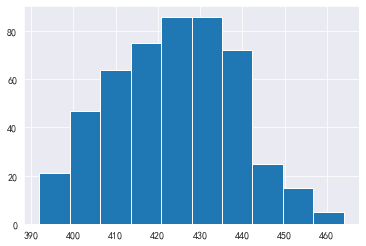

In [33]:
import matplotlib.pyplot as plt
data = pd.read_excel("../数据/配比.xlsx")
plt.hist(data["Overpotential(mV)"].values)

# 分析数据特征，进行合并
`其中OP这一行用于分割的都是3或者是4开头的两位数，所以我们将最后一行转换为字符串然后判断长度，
用于作为分割合并数据的依据。`  

In [56]:
# 这个函数用于判断OP是否满足要求
def judget_OP_split(OP)->bool:
    """ 用于判断该OP是否用于作为分解的数字"""
    if type(OP)!=str:
        return False
    if len(OP) == 2:
        if OP[0]=="3" or OP[0]=="4":
            return True #满足要求是分割数据 true
    return False # 一个要求都不满足返回false

print(judget_OP_split("23"))
print(judget_OP_split("42"))
print(judget_OP_split(np.nan))

False
True
False


In [72]:
def merege_list(original, df_row):
    """ 将df_row的数据合并到original列表上"""
    # 这里需要去除空格
    original = [x.replace(" ","")+y.replace(" ","") for x, y in zip(original,df_row.values)]
    return original

## 遍历数据来获取分割方法

In [73]:
# 备份一份数据，防止修改到原数据
split_data = train_data.copy()
split_data = split_data.fillna("")
split_data.head()

,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬,OP
0,10,58. 693,28,1.9,1.1,737,111,1.9,8,0,0,0,0,0,0,0,0,0,44
1,,,,7,7,.12,.53,1,,,,,,,,,,,1
2,,,,,,9,7,,,,,,,,,,,,
3,9.9,58.,27.,1.9,1.1,737,108,1.9,7.,0.1,0.2,0.1,0.0,0.0,19.,282,0.0,0.1,42
4,38,604,93,72,72,.91,.53,07,9,201,436,201,001,001,283,.45,001,201,6


In [74]:
for i in split_data.columns:
    print(i[0])

V
𝑹
𝑨
𝑹
𝑹
𝑭
𝑬
𝑬
𝑫
𝜹
𝜹
𝜹
𝜹
𝜹
𝜹
𝜹
𝜹
𝜹
O


In [75]:
data_to_save = pd.DataFrame(columns=split_data.columns)
data_to_save

,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬,OP


In [76]:
data_to_save.columns

Index(['VEN', '𝑹𝑨𝑴', '𝑨𝑵', '𝑹𝑨', '𝑹𝑪', '𝑭𝑰𝑬', '𝑬𝑨', '𝑬𝑷', '𝑫𝑬', '𝜹𝑽𝑬𝑵', '𝜹𝑹𝑨𝑴',
       '𝜹𝑨𝑵', '𝜹𝑹𝑨', '𝜹𝑹𝑪', '𝜹𝑭𝑰𝑬', '𝜹𝑬𝑨', '𝜹𝑬𝑷', '𝜹𝑫𝑬', 'OP'],
      dtype='object')

In [77]:
def append_data_to_save(data_to_save, tempt_list, ):
    tempt_dic = {}
    for k,v in zip(['VEN', '𝑹𝑨𝑴', '𝑨𝑵', '𝑹𝑨', '𝑹𝑪', '𝑭𝑰𝑬', '𝑬𝑨', '𝑬𝑷', '𝑫𝑬', '𝜹𝑽𝑬𝑵', '𝜹𝑹𝑨𝑴',
                    '𝜹𝑨𝑵', '𝜹𝑹𝑨', '𝜹𝑹𝑪', '𝜹𝑭𝑰𝑬', '𝜹𝑬𝑨', '𝜹𝑬𝑷', '𝜹𝑫𝑬', 'OP'],tempt_list):
        tempt_dic[k] = v
    data_to_save.loc[data_to_save.size] = tempt_dic
    return data_to_save

In [78]:
data_to_save

,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬,OP


In [79]:
tempt_list = [""]*19
for index, row in split_data.iterrows():
    content = split_data.iloc[index,:] #获得这个当前的这一行内容
    try:
        content_next = split_data.iloc[index+1,:] #获得这个当前的这一行内容
    except:
        break #越界，终止
    #print(content.values)
    current_op = row['OP']
    #print(index,judget_OP_split(current_op)) 
    if judget_OP_split(content_next['OP']):
        #如果下一行是True
        print("\n\n\n")
        print(index)
        print(tempt_list)
        data_to_save = append_data_to_save(data_to_save,tempt_list)
        tempt_list = [""]*19
    else:
        tempt_list = merege_list(tempt_list, content)
        





2
['10', '58.693', '28', '1.97', '1.17', '737.12', '111.53', '1.91', '8', '0', '0', '0', '0', '0', '0', '0', '0', '0', '441']




6
['9.938', '58.60471', '27.938', '1.97217', '1.17217', '737.9144', '108.531', '1.90752', '7.93', '0.120156', '0.243649', '0.120156', '0.000147', '0.000147', '19.28394', '282.4505', '0.000192', '0.120156', '426']




10
['9.969', '58.70044', '27.969', '1.97093', '1.17031', '737.8505', '110.0594', '1.90907', '7.96', '0.030039', '0.00173', '0.030039', '2.7E05', '3E-06', '16.2701', '68.24431', '2.7E05', '0.030039', '423']




14
['9.858', '58.49079', '27.858', '1.97497', '1.17497', '738.9279', '104.6523', '1.90432', '7.85', '0.263836', '0.535', '0.263836', '0.000323', '0.000323', '42.34328', '620.1988', '0.000422', '0.263836', '420']




18
['9.817', '58.08392', '27.655', '1.95537', '1.16195', '732.0017', '106.0496', '1.8894', '7.83', '0.15415', '0.522389', '0.208784', '0.000483', '0.000259', '78.1962', '342.5482', '0.000506', '0.15129', '422']




22
['9.9

In [80]:
data_to_save

,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬,OP
0,10,58.693,28,1.97,1.17,737.12,111.53,1.91,8,0,0,0,0,0,0,0,0,0,441
19,9.938,58.60471,27.938,1.97217,1.17217,737.9144,108.531,1.90752,7.93,0.120156,0.243649,0.120156,0.000147,0.000147,19.28394,282.4505,0.000192,0.120156,426
38,9.969,58.70044,27.969,1.97093,1.17031,737.8505,110.0594,1.90907,7.96,0.030039,0.00173,0.030039,2.7E05,3E-06,16.2701,68.24431,2.7E05,0.030039,423
57,9.858,58.49079,27.858,1.97497,1.17497,738.9279,104.6523,1.90432,7.85,0.263836,0.535,0.263836,0.000323,0.000323,42.34328,620.1988,0.000422,0.263836,420
76,9.817,58.08392,27.655,1.95537,1.16195,732.0017,106.0496,1.8894,7.83,0.15415,0.522389,0.208784,0.000483,0.000259,78.1962,342.5482,0.000506,0.15129,422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9310,8.831,58.41113,26.831,2.00676,1.19014,760.7508,55.54062,1.87155,6.83,0.140439,1.33919,0.140439,0.000225,0.000506,0.598284,341.391,0.000351,0.140439,443
9329,8.871,58.53465,26.871,2.00516,1.18774,760.6683,57.51278,1.87355,6.87,0.112359,1.071427,0.112359,0.00018,0.000404,0.47866,273.1317,0.000281,0.112359,437
9348,8.898,58.61802,26.898,2.00408,1.18612,760.6125,58.84399,1.8749,6.89,0.091596,0.873436,0.091596,0.000147,0.00033,0.390208,222.6593,0.000229,0.091596,438
9367,8.929,58.71375,26.929,2.00284,1.18426,760.5485,60.37242,1.87645,6.92,0.065959,0.628968,0.065959,0.000106,0.000237,0.280992,160.3387,0.000165,0.065959,440


# 保存数据

In [82]:
data_to_save.to_csv("../数据/ManualFeature.csv",  index=None, encoding="UTF-8")

# 这一步以后还需要手动更改一些数据

# 导入数据进行机器学习


In [6]:
train_data = pd.read_csv("../数据/ManualFeature.csv", dtype="float64")
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VEN     495 non-null    float64
 1   𝑹𝑨𝑴     495 non-null    float64
 2   𝑨𝑵      495 non-null    float64
 3   𝑹𝑨      495 non-null    float64
 4   𝑹𝑪      495 non-null    float64
 5   𝑭𝑰𝑬     495 non-null    float64
 6   𝑬𝑨      495 non-null    float64
 7   𝑬𝑷      495 non-null    float64
 8   𝑫𝑬      495 non-null    float64
 9   𝜹𝑽𝑬𝑵    495 non-null    float64
 10  𝜹𝑹𝑨𝑴    495 non-null    float64
 11  𝜹𝑨𝑵     495 non-null    float64
 12  𝜹𝑹𝑨     495 non-null    float64
 13  𝜹𝑹𝑪     495 non-null    float64
 14  𝜹𝑭𝑰𝑬    495 non-null    float64
 15  𝜹𝑬𝑨     495 non-null    float64
 16  𝜹𝑬𝑷     495 non-null    float64
 17  𝜹𝑫𝑬     495 non-null    float64
 18  OP      495 non-null    float64
dtypes: float64(19)
memory usage: 73.6 KB


In [7]:
train_data.describe()

,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬,OP
count,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,495.000000,4.950000e+02,495.000000,495.000000,495.000000,495.000000,495.000000
mean,9.004182,57.848251,27.012545,2.004232,1.197221,753.667563,63.354588,1.874157,6.995541,0.486834,1.511686,0.502523,1090.909781,2.723232e+04,109.733485,1139.994581,1090.909963,0.486059,423.771717
std,0.431100,0.787810,0.448800,0.017973,0.017244,7.068012,20.794945,0.019611,0.430128,0.237819,0.720971,0.241048,17144.946987,4.191569e+05,53.966876,558.700739,17144.946975,0.237746,14.530939
min,8.000000,55.526410,25.859000,1.955370,1.161950,732.001700,14.569000,1.817560,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,392.000000
25%,8.702000,57.254725,26.674000,1.991555,1.183780,748.654500,48.390710,1.860160,6.690000,0.294997,0.926877,0.307239,0.000440,4.690000e-04,67.515960,689.124850,0.000584,0.294839,413.000000
50%,9.005000,57.969190,27.027000,2.003370,1.195560,754.385100,63.545000,1.875030,7.000000,0.455732,1.693920,0.483036,0.000668,8.000000e-04,122.486000,1079.370000,0.000881,0.455559,424.000000
75%,9.318000,58.484055,27.341000,2.016735,1.208790,759.045350,78.365145,1.889010,7.300000,0.662111,2.094672,0.683394,0.000956,1.001000e-03,145.454600,1549.771000,0.001198,0.661942,435.000000
max,10.000000,59.462840,28.151000,2.058710,1.246890,770.432600,111.530000,1.927020,8.000000,0.997291,2.923570,1.066803,270000.000000,6.600000e+06,255.044400,2342.791000,270000.000000,0.996781,464.000000


In [8]:
from autogluon.tabular import TabularDataset, TabularPredictor
import numpy as np
import pandas as pd
from sklearn.utils import shuffle as reset
def train_test_split(data, test_size=0.3, shuffle=True, random_state=None):
    '''Split DataFrame into random train and test subsets
    
    Parameters
    ----------
    data : pandas dataframe, need to split dataset.
    
    test_size : float
        If float, should be between 0.0 and 1.0 and represent the
        proportion of the dataset to include in the train split.
        
    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.
        
    shuffle : boolean, optional (default=None)
        Whether or not to shuffle the data before splitting. If shuffle=False
        then stratify must be None.
    '''

    if shuffle:
        data = reset(data, random_state=random_state)
	
    train = data[int(len(data)*test_size):].reset_index(drop = True)
    test  = data[:int(len(data)*test_size)].reset_index(drop = True)
    
    return train, test

In [9]:
train , test = train_test_split(train_data, test_size=0.3)

In [10]:
label = "OP"
save = "My Model Save Path"

In [40]:
predictor = TabularPredictor(label=label , path=save).fit(train)

Beginning AutoGluon training ...
AutoGluon will save models to "My Model Save Path\"
AutoGluon Version:  0.4.0
Python Version:     3.9.7
Operating System:   Windows
Train Data Rows:    347
Train Data Columns: 18
Label Column: OP
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (462.0, 392.0, 423.92219, 14.28902)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...
	Available Memory:                    1993.37 MB
	Train Data (Original)  Memory Usage: 0.05 MB (0.0% of available memory)
	Inferring data type of each feature based on column values. Set feature_metadata_in to manually specify special dty

[1000]	valid_set's rmse: 6.22812


	-6.52	 = Validation score   (root_mean_squared_error)
	0.43s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-6.3767	 = Validation score   (root_mean_squared_error)
	0.89s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: CatBoost ...
	-6.2422	 = Validation score   (root_mean_squared_error)
	6.17s	 = Training   runtime
	0.0s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-6.3828	 = Validation score   (root_mean_squared_error)
	0.55s	 = Training   runtime
	0.06s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-7.7727	 = Validation score   (root_mean_squared_error)
	0.81s	 = Training   runtime
	0.02s	 = Validation runtime
Fitting model: XGBoost ...
	-6.3485	 = Validation score   (root_mean_squared_error)
	2.48s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-7.1942	 = Validation score   (root_mean_squared_error)
	2.7s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting 

In [41]:
test_nolabel = test.drop(columns = [label])
test_nolabel.head()


,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬
0,9.573,58.36617,27.573,1.98410,1.18072,744.3306,90.97291,1.89461,7.57,0.502671,0.949248,0.502671,0.000585,0.000534,122.4860,1174.0220,0.000741,0.502671
1,8.733,57.33974,26.733,2.01299,1.20757,756.0538,50.32999,1.86203,6.73,0.657711,2.223616,0.657711,0.000836,0.001056,108.3319,1551.9660,0.001130,0.657711
2,8.683,56.45436,26.449,1.98529,1.19311,743.9518,52.64229,1.83898,6.70,0.830383,2.637748,0.937254,0.001688,0.001361,231.5518,1924.2610,0.001919,0.825180
3,9.917,59.27084,28.151,2.00271,1.19089,750.1630,102.71810,1.92702,7.89,0.326621,1.132214,0.442423,0.001031,0.000560,166.1600,726.5639,0.001078,0.320601
4,8.400,56.41400,26.400,2.02600,1.22600,757.3900,33.96200,1.84600,6.40,0.640000,1.297700,0.640000,0.000700,0.000700,102.7100,1504.4000,0.001000,0.640000


In [42]:
train_nolabel = train.drop(columns = [label])
train_nolabel.head()


,VEN,𝑹𝑨𝑴,𝑨𝑵,𝑹𝑨,𝑹𝑪,𝑭𝑰𝑬,𝑬𝑨,𝑬𝑷,𝑫𝑬,𝜹𝑽𝑬𝑵,𝜹𝑹𝑨𝑴,𝜹𝑨𝑵,𝜹𝑹𝑨,𝜹𝑹𝑪,𝜹𝑭𝑰𝑬,𝜹𝑬𝑨,𝜹𝑬𝑷,𝜹𝑫𝑬
0,9.334,58.09216,27.406,2.00208,1.19684,750.1031,77.83708,1.89042,7.32,0.814938,1.813736,0.825519,0.001052,0.001024,157.9735,1910.1610,0.001344,0.814405
1,9.717,59.31884,27.951,2.00871,1.19289,754.8176,93.18531,1.92102,7.69,0.402372,1.159957,0.516958,0.001096,0.000554,222.5513,897.6460,0.001126,0.396488
2,8.681,57.66577,26.843,2.03569,1.22307,764.4869,44.44910,1.87354,6.66,0.585477,2.499866,0.637271,0.001085,0.001142,133.3346,1370.8930,0.001315,0.582991
3,9.083,57.68956,26.849,1.96929,1.16911,743.1262,72.36389,1.85898,7.10,0.431599,1.588088,0.540905,0.001144,0.000711,217.9641,973.8917,0.001198,0.426127
4,9.165,58.79832,27.237,2.00515,1.18853,758.2781,70.10987,1.88935,7.15,0.317764,0.904386,0.328248,0.000427,0.000398,108.1383,737.1932,0.000516,0.317242


In [43]:

y_test = test[label]

In [44]:

y_train = train[label]

In [45]:
y_test.astype("float32")

0      410.0
1      422.0
2      400.0
3      425.0
4      435.0
       ...  
143    432.0
144    440.0
145    426.0
146    404.0
147    413.0
Name: OP, Length: 148, dtype: float32

# 导入模型 

- 各个指标

In [46]:
predictor = TabularPredictor.load(save)
y_pred = predictor.predict(test_nolabel)
y_pred_train = predictor.predict(train_nolabel)
perf = predictor.evaluate_predictions(y_true=y_test, y_pred=y_pred, auxiliary_metrics=True)

Evaluation: root_mean_squared_error on test data: -6.960705332838512
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -6.960705332838512,
    "mean_squared_error": -48.4514187306065,
    "mean_absolute_error": -5.263541556693412,
    "r2": 0.7868116241443166,
    "pearsonr": 0.8908419015099588,
    "median_absolute_error": -4.423309326171875
}


- 各个模型的表现

In [47]:
predictor_leaderboard = predictor.leaderboard(test,silent=True)
predictor_leaderboard = predictor_leaderboard.set_index(predictor_leaderboard ["model"])

In [48]:


predictor_leaderboard.loc[:,"score_val"] = -predictor_leaderboard.loc[:,"score_val"]
predictor_leaderboard.loc[:,"score_test"] = -predictor_leaderboard.loc[:,"score_test"]
predictor_leaderboard

,model,score_test,score_val,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
model,,,,,,,,,,,,
CatBoost,CatBoost,6.959249,6.242223,0.003987,0.002994,6.168220,0.003987,0.002994,6.168220,1,True,6
WeightedEnsemble_L2,WeightedEnsemble_L2,6.960705,6.069430,0.104719,0.034868,13.190634,0.012962,0.000996,0.378525,2,True,12
LightGBMXT,LightGBMXT,7.002892,6.203874,0.020945,0.004985,0.553562,0.020945,0.004985,0.553562,1,True,3
ExtraTreesMSE,ExtraTreesMSE,7.033519,6.382754,0.072805,0.055396,0.550649,0.072805,0.055396,0.550649,1,True,7
LightGBM,LightGBM,7.186708,6.520008,0.006981,0.004986,0.433842,0.006981,0.004986,0.433842,1,True,4
RandomForestMSE,RandomForestMSE,7.214493,6.376728,0.120679,0.073804,0.885538,0.120679,0.073804,0.885538,1,True,5
XGBoost,XGBoost,7.417596,6.348549,0.023939,0.009938,2.479114,0.023939,0.009938,2.479114,1,True,9
LightGBMLarge,LightGBMLarge,7.425559,6.402824,0.019948,0.004987,0.911621,0.019948,0.004987,0.911621,1,True,11
NeuralNetTorch,NeuralNetTorch,7.624345,7.194212,0.022938,0.010970,2.699592,0.022938,0.010970,2.699592,1,True,10


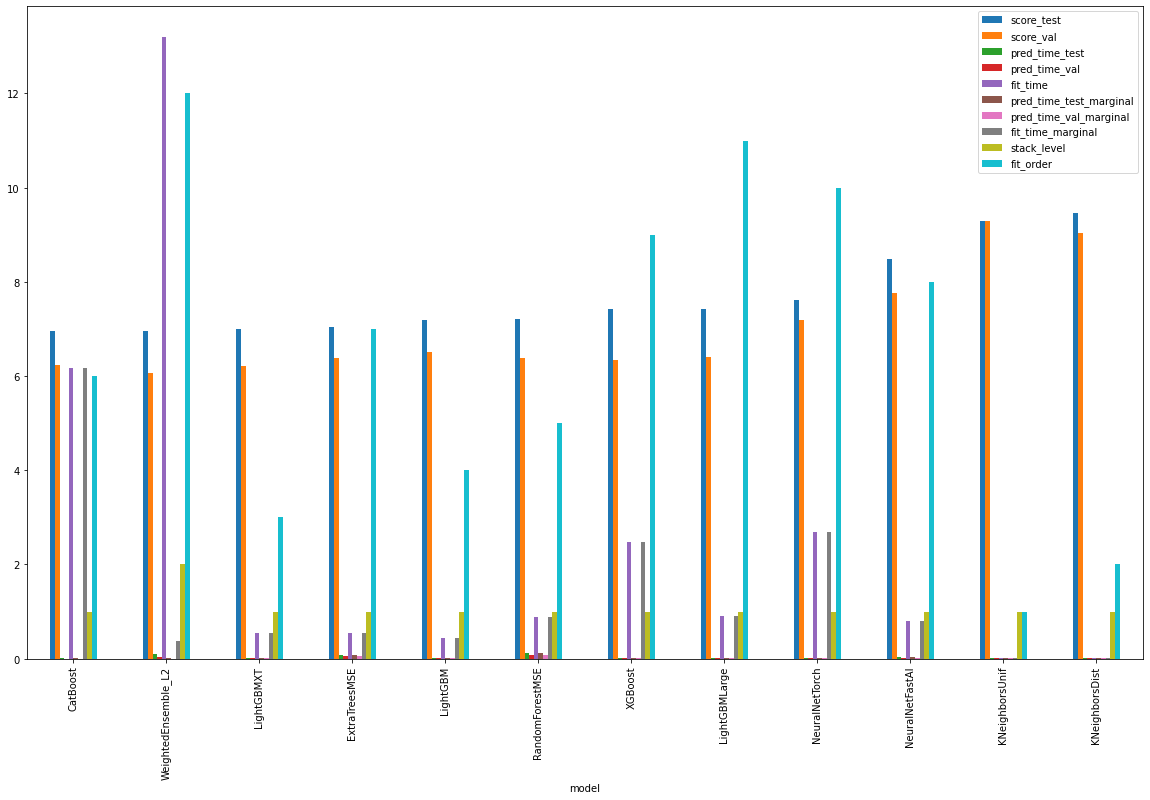

In [49]:

predictor_leaderboard.plot.bar(figsize=(20,12))
plt.savefig("所有指标.png", dpi=300)

In [27]:
predictor_leaderboard.columns

Index(['model', 'score_test', 'score_val', 'pred_time_test', 'pred_time_val',
       'fit_time', 'pred_time_test_marginal', 'pred_time_val_marginal',
       'fit_time_marginal', 'stack_level', 'can_infer', 'fit_order'],
      dtype='object')

In [28]:
predicitions.loc[:,"score_test"] = -predicitions.loc[:,"score_test"]

In [50]:
predicitions = predictor_leaderboard.drop(columns = ['pred_time_test', 'pred_time_val',
       'fit_time','pred_time_test_marginal', 'pred_time_val_marginal',
       'fit_time_marginal', 'stack_level', 'can_infer', 'fit_order'] )
predicitions

,model,score_test,score_val
model,,,
CatBoost,CatBoost,6.959249,6.242223
WeightedEnsemble_L2,WeightedEnsemble_L2,6.960705,6.069430
LightGBMXT,LightGBMXT,7.002892,6.203874
ExtraTreesMSE,ExtraTreesMSE,7.033519,6.382754
LightGBM,LightGBM,7.186708,6.520008
RandomForestMSE,RandomForestMSE,7.214493,6.376728
XGBoost,XGBoost,7.417596,6.348549
LightGBMLarge,LightGBMLarge,7.425559,6.402824
NeuralNetTorch,NeuralNetTorch,7.624345,7.194212


In [53]:
predicitions.loc[:,"score_val"] = -predicitions.loc[:,"score_val"]
predicitions.loc[:,"score_test"] = -predicitions.loc[:,"score_test"]

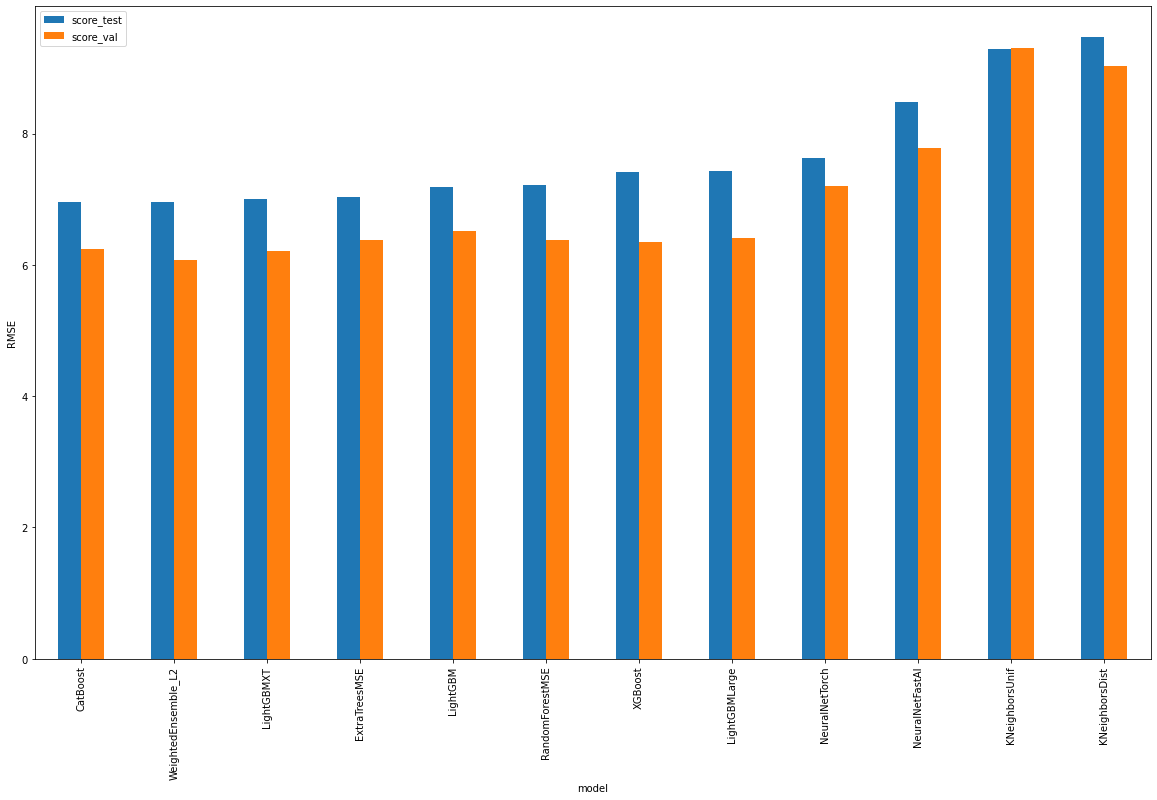

In [54]:
predicitions.plot.bar(figsize=(20,12))
plt.ylabel("RMSE")
plt.savefig("测试效果.png", dpi=300)

In [55]:
[i for i in predicitions["model"].values]

['CatBoost',
 'WeightedEnsemble_L2',
 'LightGBMXT',
 'ExtraTreesMSE',
 'LightGBM',
 'RandomForestMSE',
 'XGBoost',
 'LightGBMLarge',
 'NeuralNetTorch',
 'NeuralNetFastAI',
 'KNeighborsUnif',
 'KNeighborsDist']

In [56]:
train["OP"].values

array([403., 429., 436., 417., 429., 416., 431., 430., 413., 430., 420.,
       427., 444., 415., 410., 427., 431., 421., 454., 435., 423., 394.,
       431., 432., 429., 399., 422., 433., 404., 418., 436., 405., 415.,
       424., 392., 426., 411., 409., 414., 412., 427., 402., 413., 405.,
       437., 424., 399., 442., 424., 420., 409., 448., 434., 425., 402.,
       435., 462., 441., 421., 422., 411., 453., 417., 432., 432., 421.,
       409., 437., 425., 407., 424., 440., 426., 433., 455., 405., 406.,
       411., 424., 442., 430., 422., 415., 443., 412., 398., 413., 404.,
       457., 418., 418., 427., 453., 401., 421., 436., 424., 418., 406.,
       415., 441., 409., 441., 429., 438., 395., 435., 421., 422., 422.,
       401., 414., 422., 405., 421., 436., 442., 452., 446., 440., 415.,
       414., 415., 416., 408., 431., 438., 429., 417., 416., 441., 426.,
       404., 441., 436., 443., 427., 422., 412., 428., 443., 440., 417.,
       401., 418., 424., 412., 416., 414., 437., 42

In [57]:
test["OP"].values

array([410., 422., 400., 425., 435., 437., 426., 396., 404., 395., 445.,
       409., 440., 420., 445., 427., 431., 397., 402., 425., 455., 428.,
       428., 420., 423., 419., 407., 447., 427., 432., 407., 407., 442.,
       438., 435., 436., 405., 432., 411., 419., 431., 412., 437., 415.,
       403., 421., 417., 411., 402., 434., 435., 421., 417., 420., 456.,
       404., 438., 419., 407., 438., 416., 416., 423., 426., 416., 447.,
       405., 427., 411., 403., 406., 437., 419., 439., 429., 412., 441.,
       459., 418., 452., 409., 421., 436., 432., 415., 399., 434., 413.,
       453., 427., 427., 420., 408., 431., 435., 429., 420., 432., 418.,
       432., 409., 448., 408., 417., 405., 396., 443., 406., 447., 414.,
       413., 409., 435., 421., 404., 423., 442., 452., 411., 410., 438.,
       429., 442., 433., 435., 426., 402., 410., 421., 439., 414., 421.,
       407., 412., 445., 401., 427., 438., 406., 464., 427., 434., 427.,
       432., 440., 426., 404., 413.])

# 预测·结果图

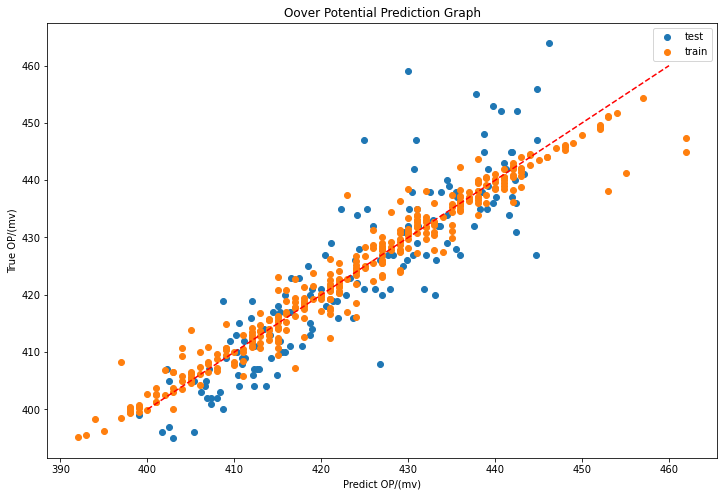

In [58]:
x = np.arange(400,460,0.01)
y = x
plt.figure(figsize=(12,8))
plt.plot(x,y,'r--')
p1 = plt.scatter(y_pred.values,y_test.values)
p2 = plt.scatter(train["OP"].values, y_pred_train)
plt.legend([p1, p2],[ "test", "train"])
plt.xlabel("Predict OP/(mv)")
plt.ylabel("True OP/(mv)")
plt.title("Oover Potential Prediction Graph")
plt.savefig("预测结果.png", dpi=300)

# 绘图

##  各个模型的预测效果图

In [132]:
predicitions = pd.DataFrame(predicitions, index=[i for i in predicitions["model"].values])
predicitions

,model,score_test,score_val
ExtraTreesMSE,ExtraTreesMSE,6.019490e+00,5.773924
LightGBMXT,LightGBMXT,6.274595e+00,6.251878
LightGBMLarge,LightGBMLarge,6.392802e+00,7.034210
CatBoost,CatBoost,6.435967e+00,6.218969
RandomForestMSE,RandomForestMSE,6.480979e+00,6.072065
WeightedEnsemble_L2,WeightedEnsemble_L2,6.483472e+00,5.444529
LightGBM,LightGBM,6.497182e+00,6.273338
NeuralNetTorch,NeuralNetTorch,7.317346e+00,5.603535
XGBoost,XGBoost,7.976532e+00,6.959762
KNeighborsDist,KNeighborsDist,8.714210e+00,7.082393


Text(0.5, 1.0, 'RMSE for both test and validation dataset')

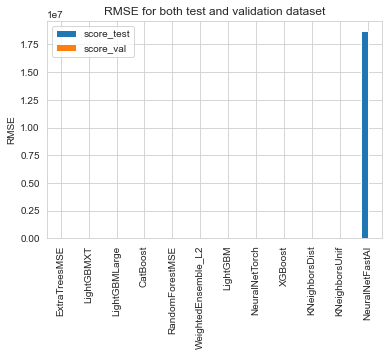

In [135]:
predicitions = pd.DataFrame(predicitions, index=[i for i in predicitions["model"].values])
predicitions.plot.bar()#(figsize=(20,12))#, index=[i for i in predicitions["model"].values])
plt.ylabel("RMSE")
plt.title("RMSE for both test and validation dataset")

<AxesSubplot:>

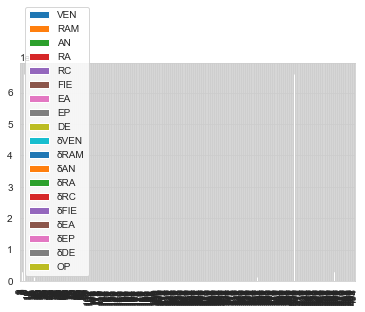

In [136]:
data.plot.bar()

### 相关性图

C:\Users\admin\AppData\Local\Temp\ipykernel_11696\2714896359.py:22: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.triu(np.ones_like(dcorr,dtype=np.bool)),#显示对脚线下面部分图


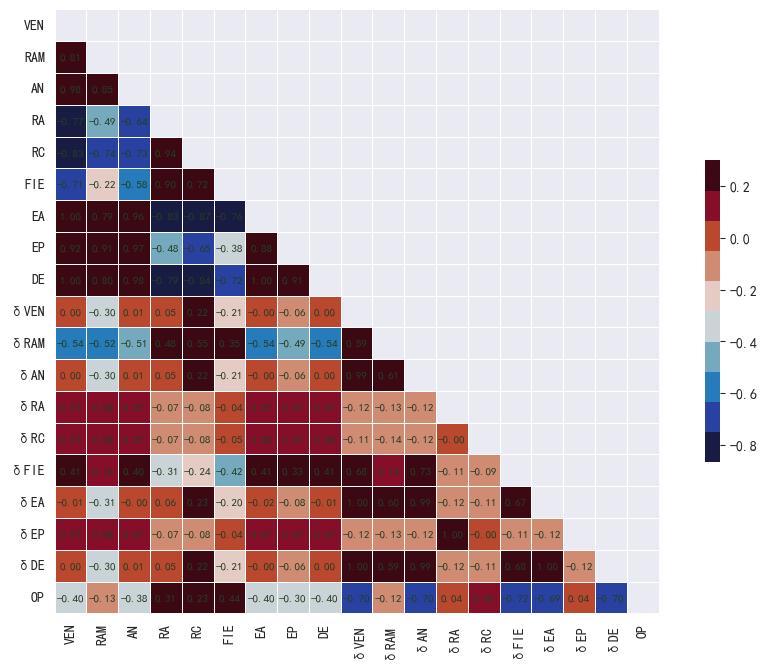

In [108]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import palettable
import matplotlib.pyplot as plt
# 支持中文
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号
data = pd.read_csv("../数据/ManualFeature.csv", dtype="float32")
data.columns = ['VEN', 'RAM', 'AN', 'RA', 'RC', 'FIE', 'EA', 'EP', 'DE', 'δVEN', 'δRAM', 'δAN','δRA', 'δRC', 'δFIE', 'δEA', 'δEP', 'δDE', 'OP']
# corr函数计算相关性矩阵(correlation matrix)
dcorr = data.corr()#(method='pearson')#默认为'pearson'检验，可选'kendall','spearman'
plt.figure(figsize=(12, 8),dpi=100)
sns.heatmap(data=dcorr,
            vmax=0.3, 
            cmap=palettable.cmocean.diverging.Balance_10.mpl_colors,
            annot=True,
            fmt=".2f",
            annot_kws={'size':8,'weight':'normal', 'color':'#253D24'},
            mask=np.triu(np.ones_like(dcorr,dtype=np.bool)),#显示对脚线下面部分图
            square=True, linewidths=.5,#每个方格外框显示，外框宽度设置
            cbar_kws={"shrink": .5}
           )
plt.savefig("皮尔逊 热力图.png",dpi=300)

In [109]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 495 entries, 0 to 494
Data columns (total 19 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VEN     495 non-null    float32
 1   RAM     495 non-null    float32
 2   AN      495 non-null    float32
 3   RA      495 non-null    float32
 4   RC      495 non-null    float32
 5   FIE     495 non-null    float32
 6   EA      495 non-null    float32
 7   EP      495 non-null    float32
 8   DE      495 non-null    float32
 9   δVEN    495 non-null    float32
 10  δRAM    495 non-null    float32
 11  δAN     495 non-null    float32
 12  δRA     495 non-null    float32
 13  δRC     495 non-null    float32
 14  δFIE    495 non-null    float32
 15  δEA     495 non-null    float32
 16  δEP     495 non-null    float32
 17  δDE     495 non-null    float32
 18  OP      495 non-null    float32
dtypes: float32(19)
memory usage: 36.9 KB


In [110]:
data.corr()

,VEN,RAM,AN,RA,RC,FIE,EA,EP,DE,δVEN,δRAM,δAN,δRA,δRC,δFIE,δEA,δEP,δDE,OP
VEN,1.000000,0.807938,0.980685,-0.774693,-0.830930,-0.711102,0.996119,0.918018,0.999446,0.002932,-0.538213,0.004337,0.073329,0.074874,0.409863,-0.009423,0.073329,0.002775,-0.396646
RAM,0.807938,1.000000,0.846879,-0.486207,-0.737355,-0.216172,0.785439,0.911602,0.801257,-0.301850,-0.521661,-0.296332,0.078077,0.079722,0.160629,-0.311672,0.078077,-0.302083,-0.126166
AN,0.980685,0.846879,1.000000,-0.636795,-0.731364,-0.580278,0.959770,0.973869,0.976001,0.007100,-0.512637,0.008505,0.069249,0.070708,0.397863,-0.004777,0.069249,0.006946,-0.379771
RA,-0.774693,-0.486207,-0.636795,1.000000,0.936632,0.901874,-0.827333,-0.483263,-0.787325,0.052115,0.480155,0.050645,-0.068223,-0.069661,-0.308658,0.062462,-0.068223,0.052241,0.313201
RC,-0.830930,-0.737355,-0.731364,0.936632,1.000000,0.715017,-0.868513,-0.646768,-0.839084,0.219734,0.554957,0.215747,-0.082159,-0.083890,-0.236120,0.230631,-0.082159,0.219929,0.225475
FIE,-0.711102,-0.216172,-0.580278,0.901874,0.715017,1.000000,-0.757136,-0.381434,-0.723614,-0.209511,0.352164,-0.207342,-0.044219,-0.045151,-0.420920,-0.200125,-0.044219,-0.209477,0.438927
EA,0.996119,0.785439,0.959770,-0.827333,-0.868513,-0.757136,1.000000,0.882761,0.997413,-0.004759,-0.544938,-0.003290,0.074658,0.076232,0.407027,-0.017175,0.074658,-0.004916,-0.395848
EP,0.918018,0.911602,0.973869,-0.483263,-0.646768,-0.381434,0.882761,1.000000,0.909610,-0.064192,-0.490981,-0.061712,0.067763,0.069191,0.328835,-0.075129,0.067763,-0.064368,-0.302559
DE,0.999446,0.801257,0.976001,-0.787325,-0.839084,-0.723614,0.997413,0.909610,1.000000,0.002112,-0.539103,0.003896,0.074034,0.075594,0.410971,-0.010303,0.074034,0.001937,-0.396956
δVEN,0.002932,-0.301850,0.007100,0.052115,0.219734,-0.209511,-0.004759,-0.064192,0.002112,1.000000,0.586484,0.993080,-0.122463,-0.114787,0.681502,0.999762,-0.122463,0.999983,-0.700499


C:\Users\admin\AppData\Local\Temp\ipykernel_11696\2003944317.py:8: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask=np.triu(np.ones_like(dcorr,dtype=np.bool)),#显示对脚线下面部分图


<Figure size 1000x1000 with 0 Axes>

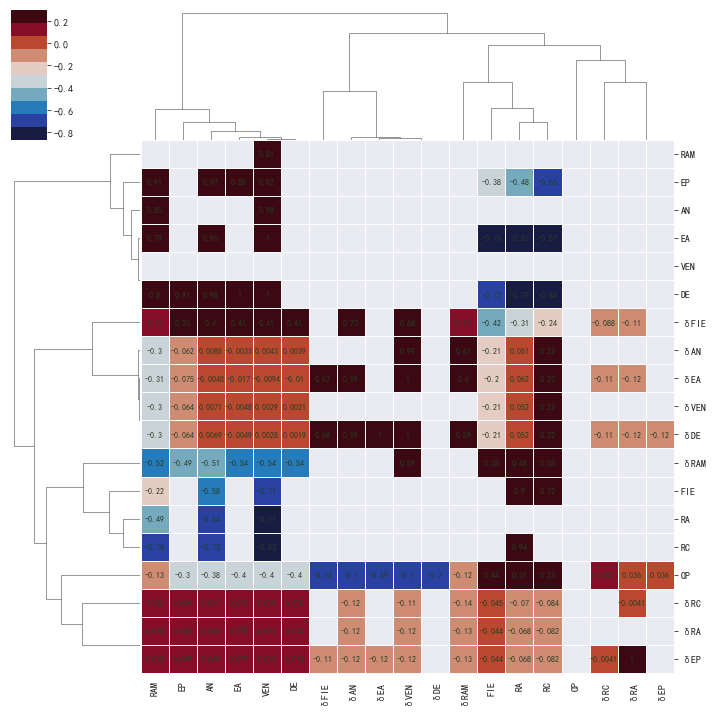

In [117]:
plt.figure(figsize=(10, 10),dpi=100)
sns.clustermap(data=dcorr,
               vmax=0.3,
               annot=True,
               cmap=palettable.cmocean.diverging.Balance_10.mpl_colors,
               linewidths=.75,
               annot_kws={'size':8,'weight':'normal', 'color':'#253D24'},
               mask=np.triu(np.ones_like(dcorr,dtype=np.bool)),#显示对脚线下面部分图
               square=True,
               cbar_kws={"shrink": .5}
                              
              )
plt.savefig("皮尔逊 聚类图.png",dpi=300)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of ticklabels (3).

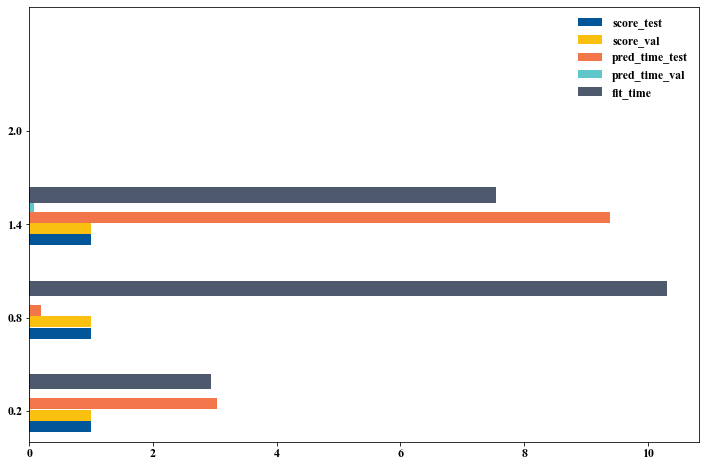

In [220]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib as mpl

import numpy as np
models = np.array(['LightGBM DSTL', 'CatBoost DSTL', 'WeightedEnsemble L2 DSTL'])
score_tests = np.array([0.997803,0.998342,0.999929])
score_val = np.array([0.9976,0.9980,1.0000])
pred_time_test = np.array([3.031554,0.186510,9.393527])
pred_time_val = np.array([0.014961,0.003990,0.077688])
fit_time = np.array([2.932168,10.305332,7.537612])
plt.figure(figsize=(12,8))
mpl.rcParams['font.sans-serif'] = ['Times New Roman']
mpl.rcParams['font.weight'] = 'bold'
mpl.rcParams['font.size'] = 12
#for model ,test ,val  = in zip(models,score_tests,score_val):
plt.barh(np.arange(0.1,0.6*(3),0.6),score_tests,height=0.07,label='score_test',color = np.array([(1,86,153)])/255 )
plt.barh(np.arange(0.1,0.6*(3),0.6)+0.072,score_val,height=0.07,label='score_val',color = np.array([(249,192,15)])/255 )
plt.barh(np.arange(0.1,0.6*(3),0.6)+0.072+0.072,pred_time_test,height=0.07,label='pred_time_test',color = np.array([(243,118,74)])/255 )
plt.barh(np.arange(0.1,0.6*(3),0.6)+0.072+0.072+0.072,pred_time_val,height=0.07,label='pred_time_val',color = np.array([(95,199,202)])/255 )
plt.barh(np.arange(0.1,0.6*(3),0.6)+0.072*4,fit_time,height=0.1,label='fit_time',color = np.array([(78,89,109)])/255 )


plt.legend(frameon=False,loc='upper right')
plt.ylim(0,2.8)
plt.xticks(np.arange(0,12,2))
plt.yticks(np.arange(0.2,0.6*(4),0.6), models, fontsize=12)
plt.ylabel('Models', fontsize=12,fontweight='bold')
plt.xlabel('Score', fontsize=12,fontweight='bold')


plt.savefig('./蒸馏模型core.png', bbox_inches='tight', dpi=300)
plt.show()